In [61]:
# Runner script for InfoVAE

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [2]:
from data import train_x, test_x, valid_x

train_size = 60000
batch_size = 32
test_size = 10000
latent_dim = 2

# normalise data
# train_x = train_x.map(lambda x: x / 255)
# test_x = test_x.map(lambda x: x / 255)
# valid_x = valid_x.map(lambda x: x / 255)
test_xn = np.array(list(test_x.as_numpy_iterator())) / 255.
train_xn = np.array(list(train_x.as_numpy_iterator())) / 255.
train_dataset = (tf.data.Dataset.from_tensor_slices(train_xn)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_xn)
                .shuffle(test_size).batch(batch_size))

Found 544 files belonging to 1 classes.
Found 9664 files belonging to 1 classes.
Found 1120 files belonging to 1 classes.


In [24]:
from model import InfoVAE
model = InfoVAE(2)
model.model.summary()
model.encoder.summary()
model.decoder.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
functional_31 (Functional)   (None, 2)                 2050946   
_________________________________________________________________
functional_33 (Functional)   (None, 256, 256, 1)       430465    
Total params: 2,481,411
Trainable params: 2,481,411
Non-trainable params: 0
_________________________________________________________________
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 254, 254, 32)      320       
____________________

In [20]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

In [25]:
from config import output_dir

def generate_and_save_images(model, epoch, test_sample):
    mean = model.encoder(test_sample)
#     z = model.reparameterize(mean, logvar)
    predictions = model.decoder(mean)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}/image_at_epoch_{:04d}.png'.format(output_dir, epoch))
    plt.show()

In [22]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10, Test set ELBO: -1, time elapse for current epoch: 24.451794624328613


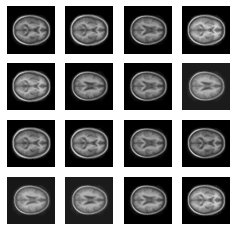

In [26]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        model.train(train_x)
    end_time = time.time()

#     loss = tf.keras.metrics.Mean()
#     for test_x in test_dataset:
#         loss(compute_loss(model, test_x))
    elbo = -1
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)